In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install surprise

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from joblib import dump, load
from scipy.stats import linregress
from sklearn.metrics import max_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from surprise.dataset import Dataset
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.reader import Reader


random_state = 14


if not os.path.exists('cached'):
    os.makedirs('cached')

## Data preprocessing

In [4]:
df_fe = pd.read_csv('first_encounters.csv', encoding='utf-8', index_col='ordinal')

In [5]:
# Get user encounter counts
user_encounter_counts = df_fe.groupby('user_id')['correct_response'].count()
user_encounter_counts.describe()

count    3778.000000
mean       41.701165
std        53.657899
min         1.000000
25%        10.000000
50%        22.000000
75%        49.000000
max       475.000000
Name: correct_response, dtype: float64

In [6]:
# significant users
user_sig = user_encounter_counts[user_encounter_counts > user_encounter_counts.quantile(0.5)]

selecting only items that have a history with our "significant" users.

In [7]:
# items that interacted with significant users
item_encounter_counts = df_fe[df_fe['user_id'].isin(user_sig.index)].groupby('item_id')['correct_response'].count()
item_encounter_counts.describe()

count    1160.000000
mean      117.343966
std        97.218139
min         1.000000
25%        33.000000
50%        99.000000
75%       173.000000
max       425.000000
Name: correct_response, dtype: float64

In [8]:
# Cull significant items
item_sig = item_encounter_counts[item_encounter_counts > item_encounter_counts.quantile(0.25)]

# How many users and items are we left with?
print(f'users: {user_sig.shape[0]}', f'items: {item_sig.shape[0]}')

users: 1848 items: 863


### Fill in sparse data
#### Perform SVD


In [9]:
# Make trainset
cached_trainset_path = 'trainset.joblib'
try:
    # Load trainset
    trainset = load(cached_trainset_path)
except:
    # Build data reader with binary "rating scale" representing wrong and right answers
    reader = Reader(rating_scale=(0, 1))

    # Build trainset from significant users and items
    trainset = Dataset.load_from_df(
        df_fe[(df_fe['user_id'].isin(user_sig.index)) & (df_fe['item_id'].isin(item_sig.index))],
        reader).build_full_trainset()

    # Save trainset
    dump(trainset, cached_trainset_path)

In [10]:
# Perform SVD
cached_svd_path = 'cached/svd.joblib'
try:
    # Load trained SVD object
    svd = load(cached_svd_path)
except:
    # Train SVD algorithm with the default 100 factors and 20 epochs
    svd = SVD(random_state=random_state).fit(trainset)

    # Save trained SVD object
    dump(svd, cached_svd_path)

#### Normalize the item biases


correlation: 0.9681455049433862


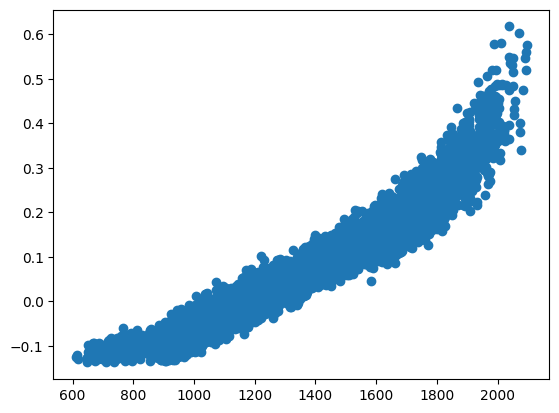

In [11]:
# Get axis labels for the trainset
user_ids = [trainset.to_raw_uid(user) for user in trainset.all_users()]
item_ids = [trainset.to_raw_iid(item) for item in trainset.all_items()]

# Associate item ids with item biases
item_biases = pd.Series(svd.bi, index=item_ids, name='item_bias')

# Get estimated ratings
df_est_ratings = pd.read_csv('/content/drive/MyDrive/data/testitem_active_est_rating.csv', encoding='utf-8', index_col='id')

# Do inverted item biases correlate positively with estimated ratings?
df_biases_ratings = df_est_ratings.merge(item_biases, left_index=True, right_index=True)
x_rating = df_biases_ratings['est_rating']
y_bias = -df_biases_ratings['item_bias']
print(f'correlation: {np.corrcoef(x_rating, y_bias)[0, 1]}')
plt.scatter(x_rating, y_bias)

#### Reconstruct the data


In [ ]:
# Construct matrix data
def construct_matrix_data(svd, trainset):
    # Assemble variables
    index = user_ids
    columns = item_ids
    global_mean = trainset.global_mean
    bu = np.array([svd.bu]).transpose()
    bi = svd.bi
    qi_T = svd.qi.transpose()
    pu = svd.pu

    # Construct dataframe
    df_md = pd.DataFrame(
        global_mean + bu + bi + np.dot(pu, qi_T),
        index=user_ids,
        columns=item_ids).clip(0, 1) # Clip to possible percent values
    return df_md

cached_matrix_data_path = 'cached/matrix_data.joblib'
try:
    # Load trained SVD object
    df_md = load(cached_matrix_data_path)
except:
    # Construct the matrix data
    df_md = construct_matrix_data(svd, trainset)

    # Save the matrix data
    dump(df_md, cached_matrix_data_path)

### Create training data
#### Determine user scores


In [ ]:
plt.hist(svd.bu)

In [ ]:
# Set threshold
threshold = 0.75

# Get sample user ids
sample_size = 5
user_sample_ids = np.random.choice(user_ids, sample_size)

# Create subplots
fig, axs = plt.subplots(sample_size, figsize=(16, 4 * sample_size), sharex=True, sharey=True)
i = 0
for label, data in df_md.loc[user_sample_ids].iterrows():
    # Plot correct chance againt item bias
    axs[i].scatter(-svd.bi, data)

    # Plot line of best fit
    line = linregress(-svd.bi, data)
    axs[i].plot(-svd.bi, line.slope * -svd.bi + line.intercept, color='red')

    # Show item bias at threshold
    thresh_bias = (threshold - line.intercept) / line.slope
    axs[i].plot(thresh_bias, threshold, marker='o', color='yellow')
    axs[i].set_title(f'thresh_bias = {thresh_bias}')

    # Increment subplot index
    i += 1

In [ ]:
# Normalize biases
def normalize_bias(bias, min_norm, max_norm):
    min_real = np.min(bias)
    max_real = np.max(bias)
    return (bias - min_real) / (max_real - min_real) * (max_norm - min_norm) + min_norm

# Get line of best fit for all users
min_norm = 20
max_norm = 120
normalized_biases = normalize_bias(-svd.bi, min_norm, max_norm)
df_lindata = pd.DataFrame(
    [linregress(normalized_biases, row[1])._asdict() for row in df_md.iterrows()],
    df_md.index)

# Get user scores clipped to (20, 120)
user_scores = ((threshold - df_lindata['intercept']) / df_lindata['slope']).clip(min_norm, max_norm)
print(user_scores.describe())
user_scores.hist()

In [ ]:
# Report metrics
def report_metrics(dt, X_test, y_test):
    print(f'model score: {dt.score(X_test, y_test)}')
    print(f'mean error: {mean_squared_error(y_test, dt.predict(X_test), squared=False)}')
    print(f'max error: {max_error(y_test, dt.predict(X_test))}')
    print(f'max tree depth: {dt.get_depth()}')

# Get training and testing data
X = df_md.clip(0.5) # Clip data minimum at pure guessing chance
y = user_scores
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

# Train model with grid search
cached_model_path = 'cached/model.joblib'
try:
    # Load model
    model = load(cached_model_path)
except:
    # Build and train model
    regressor = DecisionTreeRegressor(random_state=random_state)
    params = { 'min_samples_leaf': [1, 2, 4, 8, 16] }
    model = GridSearchCV(regressor, params).fit(X_train, y_train)

    # Save model
    dump(model, cached_model_path)
print(model.best_params_)
report_metrics(model.best_estimator_, X_test, y_test)

In [ ]:
# Simulate random right and wrong answers
random_answers = np.random.randint(0, 2, X.shape[1])
print(f'random: {model.predict([random_answers])}')

# Simulate all correct answers
perfect_answers = np.ones(X.shape[1])
print(f'perfect: {model.predict([perfect_answers])}')

In [ ]:
# Set bucket size
bucket_size = 7

# Calculate possible input values
for i in range(0, bucket_size + 1):
    print(f'{i} correct = {i / bucket_size}')

In [ ]:
# Randomly choose which item ids to keep and sort by bias
largest_sample_size = len(item_biases) - len(item_biases) % bucket_size
kept_item_ids = item_biases.sample(largest_sample_size, random_state=random_state).sort_values().index

# Split item ids into buckets
buckets = np.split(kept_item_ids, int(len(kept_item_ids) / bucket_size))
df_bucketed = pd.concat([df_md[bucket].mean(axis=1) for bucket in buckets], axis=1)
print(df_bucketed.shape)
df_bucketed.head()

Now we have 1,931 features for our decision tree to choose from instead of 13,517. So training our model again.

In [ ]:
# Get training and testing data
Xb = df_bucketed.clip(0.5) # Clip data minimum to pure guessing chance
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, y)

# Train model with grid search
cached_modelb_path = 'cached/modelb.joblib'
try:
    # Load model
    modelb = load(cached_modelb_path)
except:
    # Build and train model
    regressor = DecisionTreeRegressor(random_state=random_state)
    params = { 'min_samples_leaf': [1, 2, 4, 8, 16] }
    modelb = GridSearchCV(regressor, params).fit(Xb_train, yb_train)

    # Save model
    dump(modelb, cached_modelb_path)
print(modelb.best_params_)
report_metrics(modelb.best_estimator_, Xb_test, yb_test)

In [ ]:
# Simulate random right and wrong answers
random_answers_b = np.full(Xb.shape[1], 0.5)
print(f'random: {modelb.predict([random_answers_b])}')

# Simulate all correct answers
perfect_answers_b = np.ones(Xb.shape[1])
print(f'perfect: {modelb.predict([perfect_answers_b])}')

In [ ]:
pd.DataFrame(modelb.best_estimator_.decision_path(Xb_test).todense()).sum(axis=1).describe()